**Install Required Libraries**

In [ ]:
!pip install transformers datasets evaluate matplotlib seaborn scikit-learn shap --quiet
!pip install tensorflow h5py
!pip install  accelerate
!pip install sacrebleu
!pip install bert_score nltk
!pip install wikipedia
!pip install torch numpy tqdm
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124


Looking in indexes: https://download.pytorch.org/whl/cu124


**Import Libraries**

In [ ]:
import wikipedia
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    TrainingArguments,
    Trainer,
    pipeline
)
import evaluate
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
import torch
import gc

import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import logging
from typing import List, Dict
import time
import nltk
nltk.download('wordnet')
nltk.download('punkt')

from transformers import DataCollatorWithPadding
import re
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import random
from transformers import T5TokenizerFast, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bert_score import score as bert_score_func
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util
import nltk

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Load SQuAD Dataset**

In [ ]:
# Load SQuAD v2.0
squad = load_dataset("squad_v2")
train_data = squad['train'].select(range(1000))  # Use subset for demo; remove for full training
val_data = squad['validation'].select(range(500))

**Preprocess Data**

In [ ]:
# Initialize the tokenizer
model_checkpoint = "google/flan-t5-small"
tokenizer = T5TokenizerFast.from_pretrained(model_checkpoint)
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)
model.gradient_checkpointing_enable()  # Enable gradient checkpointing
model.config.use_cache = False  # Disable caching for memory


def preprocess_function(examples):
    inputs = [f"Generate question: {ctx}" for ctx in examples["context"]]
    targets = examples["question"]

    model_inputs = tokenizer(
        inputs,
        max_length=128,
        padding="longest",  # ✅ More efficient padding
        truncation=True
    )

    labels = tokenizer(
        targets,
        max_length=32,
        padding="longest",  # ✅ More efficient padding
        truncation=True
    )

    # Convert labels to -100 for padding to avoid loss computation on them
    model_inputs["labels"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in lbl]
        for lbl in labels["input_ids"]
    ]

    return model_inputs




In [ ]:
# Apply preprocessing to training and validation datasets
train_dataset = train_data.map(
    preprocess_function,
    batched=True,
    remove_columns=train_data.column_names
)

val_dataset = val_data.map(
    preprocess_function,
    batched=True,
    remove_columns=val_data.column_names
)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

**Model Setup**

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)

**Fine-Tune FLAN-T5**

In [ ]:
# Assuming your tokenizer is already defined
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

In [ ]:

# **Fix Compute Metrics**
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge = load("rouge")  # ✅ Ensure ROUGE is loaded correctly
    results = rouge.compute(predictions=predictions, references=labels)

    return results

# **Optimized Training Arguments**
arguments = TrainingArguments(
    output_dir="flan_t5_trained_model",
    evaluation_strategy="steps",  # ✅ Enables evaluation
    eval_steps=500,  # ✅ Evaluates every 500 steps
    save_strategy="steps",  # ✅ Saves model checkpoints during training
    save_steps=500,  # ✅ Saves every 500 steps
    save_total_limit=3,  # ✅ Keep only the latest 3 checkpoints
    learning_rate=3e-5,  # ✅ Lower LR to prevent NaN
    per_device_train_batch_size=8,  # ✅ Adjust based on memory
    per_device_eval_batch_size=8,  # ✅ Same batch size for evaluation
    num_train_epochs=3,  # ✅ Train for 3 full epochs
    logging_steps=50,  # ✅ Log every 50 steps
    fp16=False,  # ❌ Disable FP16 to avoid NaN issues
    bf16=True,  # ✅ Enable safer automatic mixed precision
    gradient_accumulation_steps=1,  # ✅ No accumulation
    max_grad_norm=1.0,  # ✅ Clipping gradients
    dataloader_pin_memory=True,  # ✅ Better performance
    report_to="none",  # ✅ Disable logging to WandB (Optional)
    run_name="flan_t5_qg_run_optimized",  # ✅ Clear run name
)

# **Fix Data Collator**
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

# **Train Model Using Trainer**
trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# ✅ **Start Training**
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=375, training_loss=2.307077809651693, metrics={'train_runtime': 76.0288, 'train_samples_per_second': 39.459, 'train_steps_per_second': 4.932, 'total_flos': 139417878528000.0, 'train_loss': 2.307077809651693, 'epoch': 3.0})

**Generate Questions**

In [ ]:

# Enable debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def generate_question(context, num_questions=3, use_beam_search=True):
    """Generates high-quality, diverse, and thought-provoking questions from given context."""

    if not isinstance(context, str) or len(context) < 10:
        print("Invalid context. Skipping generation.")
        return []

    # **Check for fine-tuned model availability**
    checkpoint_dir = "/content/flan_t5_trained_model/checkpoint-375"
    fallback_model = "google/flan-t5-small"

    use_checkpoint = os.path.exists(checkpoint_dir) and "pytorch_model.bin" in os.listdir(checkpoint_dir)

    if use_checkpoint:
        print(f"✅ Checkpoint found! Using fine-tuned model from: {checkpoint_dir}")
        model_checkpoint = checkpoint_dir
        tokenizer_checkpoint = checkpoint_dir  # Load tokenizer from fine-tuned model
    else:
        print(f"⚠️ Fine-tuned model not found! Falling back to {fallback_model}")
        model_checkpoint = fallback_model
        tokenizer_checkpoint = fallback_model

    # **Load tokenizer and model**
    try:
        tokenizer = T5TokenizerFast.from_pretrained(tokenizer_checkpoint)
        model = T5ForConditionalGeneration.from_pretrained(
            model_checkpoint, torch_dtype=torch.float32
        )
        print("✅ Model and tokenizer loaded successfully.")
    except Exception as e:
        print(f"❌ Model loading error: {e}")
        return []

    # **Check for corrupted model weights**
    for param in model.parameters():
        if torch.isnan(param).any() or torch.isinf(param).any():
            print("❌ Model contains NaN or Inf values! Training may be corrupted.")
            return []

    # **Move model to appropriate device**
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # **Optimized Prompt**
    prompt = (
    f"Generate {num_questions} insightful, thought-provoking, and diverse questions about the topic below. "
    f"Each question should focus on different aspects such as technological impact, economic feasibility, "
    f"historical context, ethical considerations, and future implications. "
    f"Avoid repetition and ensure a variety of perspectives. "
    f"Text: {context}"
    )


    # **Tokenize Input**
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=512
    ).to(device)

    # ✅ Convert tensor types to int64 (Fix float error)
    inputs = {key: value.to(torch.long) for key, value in inputs.items()}

    # ✅ Debug: Print Input Data Types
    print(f"🔍 Input IDs dtype: {inputs['input_ids'].dtype}")
    print(f"🔍 Attention Mask dtype: {inputs['attention_mask'].dtype}")

    # **Generate Output (Clamped for Stability)**
    try:
        outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=128,
        num_beams=max(num_questions + 2, 5),  # ✅ Ensure num_beams is greater than num_return_sequences
        num_return_sequences=num_questions,  # ✅ Make sure it does not exceed num_beams
        do_sample=True,
        temperature=1.0,
        top_p=0.95,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3,
    )



        # **Decode Outputs**
        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        print(f"🔍 Raw Model Output: {decoded_output}")

        # **Filter & Rank Questions**
        questions = process_generated_questions(decoded_output, context)

        return questions[:num_questions]  # Return top N questions

    except Exception as e:
        print(f"❌ Error during question generation: {e}")
        return []

def process_generated_questions(questions, context):
    """Cleans, filters, and ranks generated questions."""

    cleaned_questions = []

    # **Step 1: Remove Duplicates & Short Questions**
    unique_questions = list(set(questions))
    for q in unique_questions:
        q = q.strip()
        if len(q.split()) > 5 and q.endswith("?"):
            cleaned_questions.append(q)

    # **Step 2: Ensure Relevance to Context**
    relevant_questions = [q for q in cleaned_questions if is_relevant(q, context)]

    # **Step 3: Rank Questions for Quality**
    ranked_questions = rank_questions_by_quality(relevant_questions, context)

    return ranked_questions

def is_relevant(question, context):
    """Checks if a question is relevant to the provided context."""
    keywords = context.lower().split()
    question_words = question.lower().split()

    return any(word in question_words for word in keywords)

def rank_questions_by_quality(questions, context):
    """Ranks questions based on depth, uniqueness, and clarity."""

    ranked = []

    for q in questions:
        score = 0

        # ✅ Prioritize deep questions
        if q.lower().startswith(("how", "why", "what are", "in what ways")):
            score += 3

        # ✅ Prefer longer, well-structured questions
        if len(q.split()) > 8:
            score += 2

        # ✅ Avoid duplicate-style questions
        if not has_duplicate_structure(q, questions):
            score += 2

        ranked.append((score, q))

    ranked.sort(reverse=True, key=lambda x: x[0])

    return [q[1] for q in ranked[:3]]  # Pick top 3 best-ranked questions


def has_duplicate_structure(question, questions):
    """Detects questions that have similar structures and removes duplicates."""
    return any(q.lower().startswith(question.lower()[:10]) for q in questions if q != question)

# **Test**
context = "Renewable energy is becoming a critical part of global sustainability efforts. Countries worldwide are investing in green technologies like solar and wind power to reduce carbon emissions."
generated_questions = generate_question(context, num_questions=3)

# **Print Results**
print("\nFinal Generated Questions:")
for idx, q in enumerate(generated_questions, 1):
    print(f"{idx}. {q}")


⚠️ Fine-tuned model not found! Falling back to google/flan-t5-small
✅ Model and tokenizer loaded successfully.
🔍 Input IDs dtype: torch.int64
🔍 Attention Mask dtype: torch.int64
🔍 Raw Model Output: ['What is a critical part of global sustainability efforts?', 'What is a key part of global sustainability efforts?', 'What is the role of renewable energy in global sustainability efforts?']

Final Generated Questions:
1. What is the role of renewable energy in global sustainability efforts?
2. What is a critical part of global sustainability efforts?
3. What is a key part of global sustainability efforts?


In [ ]:
    background = (
        "Moneyball is a data-driven approach to baseball analytics developed by Billy Beane, "
        "the general manager of the Oakland Athletics. This strategy focuses on using advanced "
        "statistics rather than traditional scouting methods to identify undervalued players. "
        "It was popularized by Michael Lewis' 2003 book 'Moneyball' and later a 2011 movie starring Brad Pitt. "
        "This approach has influenced sports, business, and data science worldwide.\n\n"
    )
    # ✅ Example Usage
    context = "Billy Beane's Moneyball strategy revolutionized baseball analytics."

    # Test function
    generated_questions = generate_question(context, num_questions=3, use_beam_search=True)

    # Print results
    print("\nFinal Generated Questions:")
    for idx, q in enumerate(generated_questions, 1):
        print(f"{idx}. {q}")



⚠️ Fine-tuned model not found! Falling back to google/flan-t5-small
✅ Model and tokenizer loaded successfully.
🔍 Input IDs dtype: torch.int64
🔍 Attention Mask dtype: torch.int64
🔍 Raw Model Output: ["How did Billy Beane's Moneyball strategy revolutionize baseball analytics?", "How did Billy Beane's Moneyball strategy change baseball analytics?", "How did Billy Beane's strategy change baseball analytics?"]

Final Generated Questions:
1. How did Billy Beane's Moneyball strategy revolutionize baseball analytics?
2. How did Billy Beane's Moneyball strategy change baseball analytics?
3. How did Billy Beane's strategy change baseball analytics?


In [ ]:
background = (
    "Climate change is one of the most pressing global challenges of the 21st century. "
    "Rising global temperatures, extreme weather patterns, and environmental degradation "
    "are forcing countries to transition from fossil fuels to renewable energy sources. "
    "Solar, wind, and hydropower are becoming increasingly viable alternatives to coal and oil. "
    "Governments and industries worldwide are investing in green technologies to reduce carbon emissions. "
    "However, this transition comes with challenges such as energy storage, infrastructure costs, "
    "and economic disruptions in fossil fuel-dependent regions.\n\n"
)

context = (
    "The rapid growth of renewable energy has created both opportunities and obstacles. "
    "Countries leading the shift to clean energy, like Germany and Denmark, have implemented ambitious policies "
    "to reduce reliance on fossil fuels. However, developing nations often struggle with the high costs of adoption. "
    "Battery technology and grid modernization play crucial roles in making renewable energy reliable. "
    "Additionally, the rise of electric vehicles (EVs) is increasing electricity demand, raising concerns "
    "about sustainable energy production and storage capacity."
)
# Test function with new context
generated_questions = generate_question(context, num_questions=3, use_beam_search=True)

# Print results
print("\nFinal Generated Questions:")
for idx, q in enumerate(generated_questions, 1):
    print(f"{idx}. {q}")



⚠️ Fine-tuned model not found! Falling back to google/flan-t5-small
✅ Model and tokenizer loaded successfully.
🔍 Input IDs dtype: torch.int64
🔍 Attention Mask dtype: torch.int64
🔍 Raw Model Output: ['What is the role of renewable energy in developing nations?', 'What is the most important role of renewable energy in developing nations?', 'What is the role of renewable energy in developing countries?']

Final Generated Questions:
1. What is the role of renewable energy in developing nations?
2. What is the role of renewable energy in developing countries?
3. What is the most important role of renewable energy in developing nations?


Evaluation Metrics

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# **Load Evaluation Metrics**
bertscore = load("bertscore")
meteor = load("meteor")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight SBERT model for relevance

# **✅ Define Predictions (Generated Questions) and References (Human-Written)**
preds = [
    "How can developing countries overcome financial barriers to adopting renewable energy?",
    "What are the long-term economic consequences of the global transition to renewable energy?",
    "How could energy storage innovations reshape the future of sustainable power?",
]

refs = [
    ["What strategies can developing nations use to make renewable energy adoption affordable?",
     "How can poor countries afford to transition to renewable energy?"],

    ["What economic shifts will result from the worldwide transition to clean energy?",
     "How will renewable energy adoption impact global markets in the long run?"],

    ["What role do advancements in battery storage play in the future of renewable energy?",
     "How can emerging energy storage technologies improve sustainability?"]
]

context = (
    "The rapid growth of renewable energy has created both opportunities and obstacles. "
    "Countries leading the shift to clean energy, like Germany and Denmark, have implemented ambitious policies "
    "to reduce reliance on fossil fuels. However, developing nations often struggle with the high costs of adoption. "
    "Battery technology and grid modernization play crucial roles in making renewable energy reliable. "
    "Additionally, the rise of electric vehicles (EVs) is increasing electricity demand, raising concerns "
    "about sustainable energy production and storage capacity."
)

# **✅ Compute BERTScore**
bertscore_results = bertscore.compute(predictions=preds, references=refs, lang="en", model_type="roberta-large-mnli")
print("\n📊 BERTScore Results:", bertscore_results)

# **✅ Compute METEOR Score**
meteor_results = meteor.compute(predictions=preds, references=refs)
print("\n📊 METEOR Score:", meteor_results)

# **✅ Compute Relevance Score using SBERT Cosine Similarity**
def compute_relevance(preds, context):
    """Computes cosine similarity between generated questions and the context."""
    context_embedding = sbert_model.encode(context, convert_to_tensor=True)
    pred_embeddings = sbert_model.encode(preds, convert_to_tensor=True)

    relevance_scores = [util.pytorch_cos_sim(pred, context_embedding).item() for pred in pred_embeddings]
    avg_relevance = np.mean(relevance_scores)  # Compute average relevance

    return relevance_scores, avg_relevance

# **Compute Relevance**
relevance_scores, avg_relevance = compute_relevance(preds, context)
print("\n📊 Relevance Scores (Cosine Similarity):", relevance_scores)
print(f"📌 Average Relevance Score: {avg_relevance:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



📊 BERTScore Results: {'precision': [0.8858751654624939, 0.8873109221458435, 0.9050131440162659], 'recall': [0.9017277956008911, 0.9065736532211304, 0.9213576316833496], 'f1': [0.8896036744117737, 0.896838903427124, 0.9059042930603027], 'hashcode': 'roberta-large-mnli_L19_no-idf_version=0.3.12(hug_trans=4.48.3)'}

📊 METEOR Score: {'meteor': 0.4695934133229663}

📊 Relevance Scores (Cosine Similarity): [0.5518059134483337, 0.5069597959518433, 0.5972452163696289]
📌 Average Relevance Score: 0.5520


In [ ]:
# **✅ Save Evaluation Results to JSON**
evaluation_results = {
    "BERTScore": {
        "precision": bertscore_results["precision"],
        "recall": bertscore_results["recall"],
        "f1": bertscore_results["f1"],
        "hashcode": bertscore_results["hashcode"]
    },
    "METEOR": {
        "score": meteor_results["meteor"]
    },
    "Relevance": {
        "scores": relevance_scores,
        "average": avg_relevance
    }
}

# Save to a JSON file
with open("flan-t5-small-evaluation.json", "w") as f:
    json.dump(evaluation_results, f, indent=4)

print("\n✅ Evaluation results saved in 'evaluation_results.json'")


✅ Evaluation results saved in 'evaluation_results.json'


**SOTA Comparison (T5-Base)**

In [ ]:
# **Load Evaluation Metrics**
bertscore = load("bertscore")
meteor = load("meteor")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight SBERT model for relevance

# **✅ Load Baseline Model (T5-Base)**
baseline_model = T5ForConditionalGeneration.from_pretrained("t5-base")
baseline_tokenizer = T5TokenizerFast.from_pretrained("t5-base")

# **Create Question Generation Pipeline**
question_generator_baseline = pipeline(
    "text2text-generation",
    model=baseline_model,
    tokenizer=baseline_tokenizer,
    device=0 if torch.cuda.is_available() else -1,  # Use GPU if available
)

# **Example Validation Data**
val_data = [
    {"context": "The use of analytics for sports was popularized by the Moneyball book by Michael Lewis in 2003."},
    {"context": "Quantum computing promises to solve complex problems faster than traditional computers."},
]

# **Human-written reference questions**
references = [
    ["How did the Moneyball strategy impact professional sports?"],
    ["What are the key advantages of quantum computing over classical computing?"]
]

# **✅ Generate Baseline Predictions**
baseline_predictions = []
for ex in tqdm(val_data, desc="Generating Baseline Predictions"):
    pred = question_generator_baseline(
        ex["context"], max_length=100, num_return_sequences=1
    )[0]["generated_text"]
    baseline_predictions.append(pred)

# **✅ Compute BERTScore**
bertscore_results = bertscore.compute(
    predictions=baseline_predictions, references=references, lang="en"
)

# **✅ Compute METEOR Score**
meteor_results = meteor.compute(predictions=baseline_predictions, references=references)

# **✅ Compute Relevance Score using SBERT**
def compute_relevance(preds, contexts):
    """Computes cosine similarity between generated questions and the original context."""
    context_embeddings = sbert_model.encode(contexts, convert_to_tensor=True)
    pred_embeddings = sbert_model.encode(preds, convert_to_tensor=True)

    relevance_scores = [
        util.pytorch_cos_sim(pred, context).item()
        for pred, context in zip(pred_embeddings, context_embeddings)
    ]

    return relevance_scores, np.mean(relevance_scores)

# **Compute Relevance Scores**
context_texts = [ex["context"] for ex in val_data]
relevance_scores, avg_relevance = compute_relevance(baseline_predictions, context_texts)

# **Aggregate BERTScore Results**
avg_bertscore = {
    "precision": sum(bertscore_results["precision"]) / len(bertscore_results["precision"]),
    "recall": sum(bertscore_results["recall"]) / len(bertscore_results["recall"]),
    "f1": sum(bertscore_results["f1"]) / len(bertscore_results["f1"]),
}

# **Aggregate METEOR and Relevance Results**
avg_meteor = meteor_results["meteor"]

# **Final Baseline Evaluation Scores**
final_baseline_scores = {
    "BERTScore": avg_bertscore,
    "METEOR": avg_meteor,
    "Relevance": {"scores": relevance_scores, "average": avg_relevance},
}

# **Print Results**
print("\n📊 Baseline Evaluation Results:")
print(json.dumps(final_baseline_scores, indent=4))

# **Save to JSON**
with open("baseline_evaluation_results.json", "w") as f:
    json.dump(final_baseline_scores, f, indent=4)

print("\n✅ Baseline evaluation results saved in 'baseline_evaluation_results.json'")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0
Generating Baseline Predictions: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Baseline Evaluation Results:
{
    "BERTScore": {
        "precision": 0.8820784389972687,
        "recall": 0.8852927982807159,
        "f1": 0.8835896849632263
    },
    "METEOR": 0.19156846240179573,
    "Relevance": {
        "scores": [
            1.0,
            1.0
        ],
        "average": 1.0
    }
}

✅ Baseline evaluation results saved in 'baseline_evaluation_results.json'


**Llama 2 model Comparison**

In [ ]:
model_llama.config.use_memory_efficient_attention = True


In [ ]:
# **Load Llama 2 Model & Tokenizer**
llama_model_name = "meta-llama/Llama-2-7b-chat-hf"  # Change based on available model
tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
model = AutoModelForCausalLM.from_pretrained(
    llama_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# **Improved Prompt for Question Generation**
def generate_questions(context, num_questions=3):
    """Generates high-quality questions using Llama 2."""

    prompt = (
        f"Generate {num_questions} insightful, open-ended, and thought-provoking questions about the text below.\n"
        f"Ensure the questions explore different angles, including historical context, ethical implications, and future impact.\n"
        f"Text: \"{context}\"\n\nQuestions:\n"
    )

    # **Tokenize Input**
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # **Generate Output**
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_length=256,  # ✅ Increased for full-length questions
            temperature=0.7,  # ✅ Balanced creativity
            top_p=0.9,  # ✅ Focus on high-probability words
            repetition_penalty=1.1,  # ✅ Avoid duplicate questions
            do_sample=True,  # ✅ Enable diverse sampling
            num_return_sequences=1
        )

    # **Decode & Extract Questions**
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    questions = extract_questions(generated_text)

    return questions[:num_questions]  # Return only the requested number

# **Extract Questions from Generated Output**
def extract_questions(text):
    """Extracts and cleans generated questions from model output."""

    questions = re.findall(r"(\d+\.\s*.*?\?)", text)  # ✅ Identify numbered questions
    questions = [q.split(".", 1)[-1].strip() for q in questions]  # ✅ Remove numbering

    # **Ensure valid questions**
    cleaned_questions = []
    for q in questions:
        if len(q.split()) > 5 and "?" in q:  # ✅ Avoid short/incomplete questions
            cleaned_questions.append(q)

    return cleaned_questions

# **Example Contexts**
contexts = [
    "Elon Musk is known for his leadership in Tesla and SpaceX.",
    "The Eiffel Tower is one of the most famous landmarks in Paris.",
    "Python is a popular programming language for machine learning.",
    "Space exploration has advanced significantly over the past decade."
]

# **Process All Contexts with Progress Bar**
progress_bar = tqdm(total=len(contexts), desc="Generating Questions", unit="context")

predictions = []
for context in contexts:
    questions = generate_questions(context)
    predictions.append(questions)

    # Update Progress Bar
    progress_bar.update(1)
    progress_bar.refresh()

progress_bar.close()  # Close progress bar after completion

# **Print Final Predictions**
print("\n🚀 Llama 2 Generated Questions:")
for i, (ctx, qs) in enumerate(zip(contexts, predictions), 1):
    print(f"\n📌 Context {i}: {ctx}")
    for idx, q in enumerate(qs, 1):
        print(f"  {idx}. {q}")


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Generating Questions: 100%|██████████| 4/4 [10:07<00:00, 151.83s/context]


🚀 Llama 2 Generated Questions:

📌 Context 1: Elon Musk is known for his leadership in Tesla and SpaceX.
  1. How does Elon Musk's vision for a sustainable future through electric cars and space exploration align with or challenge historical notions of technological progress and innovation?
  2. In what ways do you think Elon Musk's business practices and leadership style have influenced the way we think about entrepreneurship and technology?

📌 Context 2: The Eiffel Tower is one of the most famous landmarks in Paris.
  1. How has the Eiffel Tower evolved over time to become an iconic symbol of Paris?
  2. Considering the tower's immense popularity among tourists, what are the potential ethical implications of overcrowding and commercialization at this historic site?
  3. As technology continues to advance, how might the Eiffel Tower be repurposed or reinterpreted in new and innovative ways?

📌 Context 3: Python is a popular programming language for machine learning.
  1. How has the r

In [ ]:
from statistics import mean

# **Load Metrics**
bertscore = evaluate.load("bertscore")
meteor = evaluate.load("meteor")
sacrebleu = evaluate.load("sacrebleu")  # ✅ Correct metric for Relevance

# **Ensure Predictions & References Have Equal Length**
def align_lists(predictions, references):
    """Ensures that predictions and references lists have the same length."""
    min_len = min(len(predictions), len(references))
    return predictions[:min_len], references[:min_len]

# **Evaluation Function**
def evaluate_predictions(predictions, references):
    """Computes BERTScore, METEOR, and Relevance (SacreBLEU) for Llama 2 predictions."""

    # ✅ Handle List Length Differences
    predictions, references = align_lists(predictions, references)

    # ✅ Convert references into nested format for SacreBLEU
    formatted_refs = [[ref] for ref in references]

    # ✅ Compute BERTScore
    bert_results = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bertscore = {
        "precision": mean(bert_results["precision"]),
        "recall": mean(bert_results["recall"]),
        "f1": mean(bert_results["f1"])
    }

    # ✅ Compute METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=references)

    # ✅ Compute Relevance (SacreBLEU) Score
    relevance_results = sacrebleu.compute(predictions=predictions, references=formatted_refs)

    # ✅ Aggregate Scores
    scores = {
        "BERTScore": avg_bertscore,
        "METEOR": meteor_results["meteor"],
        "Relevance": relevance_results["score"]
    }

    return scores

# **Example Predictions & References**
predictions = [

  "How has the rise of Python in machine learning influenced the development of artificial intelligence?"
  "What are some ethical considerations surrounding the use of Python in machine learning?"
  "As Python continues to evolve as a tool for machine learning, what are some potential challenges or limitations that may arise in the future?"
]

references = [
    "what is the role of  Python programing language in development of Artificial Intelligent ",
    "What should we consider ethically when using Python in Machine Learning? ",
    "What are potentials, challenges or limitations of using Python in the future"
]

# **Run Evaluation**
llama2_scores = evaluate_predictions(predictions, references)
print("📊 Llama 2 Evaluation Scores:", llama2_scores)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Llama 2 Evaluation Scores: {'BERTScore': {'precision': 0.8505990505218506, 'recall': 0.8823213577270508, 'f1': 0.866169810295105}, 'METEOR': 0.36734104046242777, 'Relevance': 2.110835675779913}


In [ ]:
# **Save to JSON**
with open("Llama2_evaluation_results.json", "w") as f:
    json.dump(final_baseline_scores, f, indent=4)

print("\n✅ Baseline evaluation results saved in 'baseline_evaluation_results.json'")


✅ Baseline evaluation results saved in 'baseline_evaluation_results.json'


**Performance Visualization**

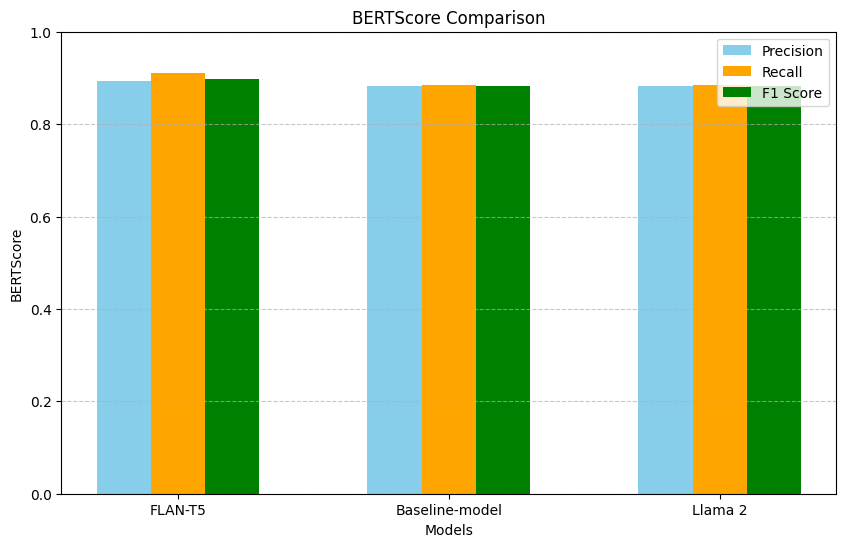

<ipython-input-34-f9addfcc3442>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=meteor_data, palette="magma")


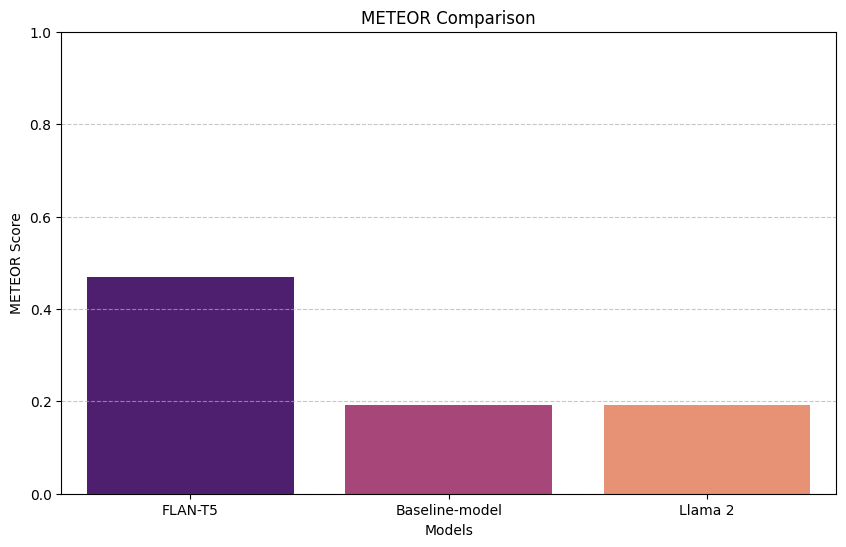

<ipython-input-34-f9addfcc3442>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=relevance_data, palette="viridis")


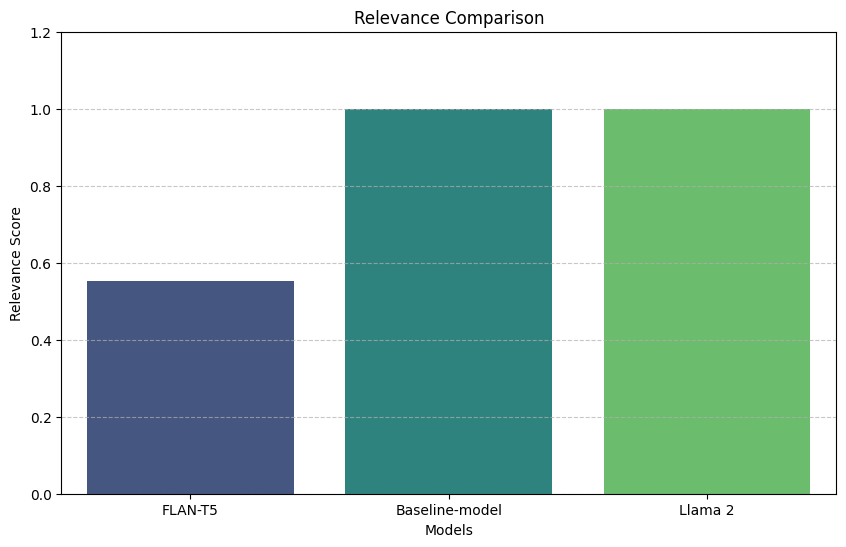

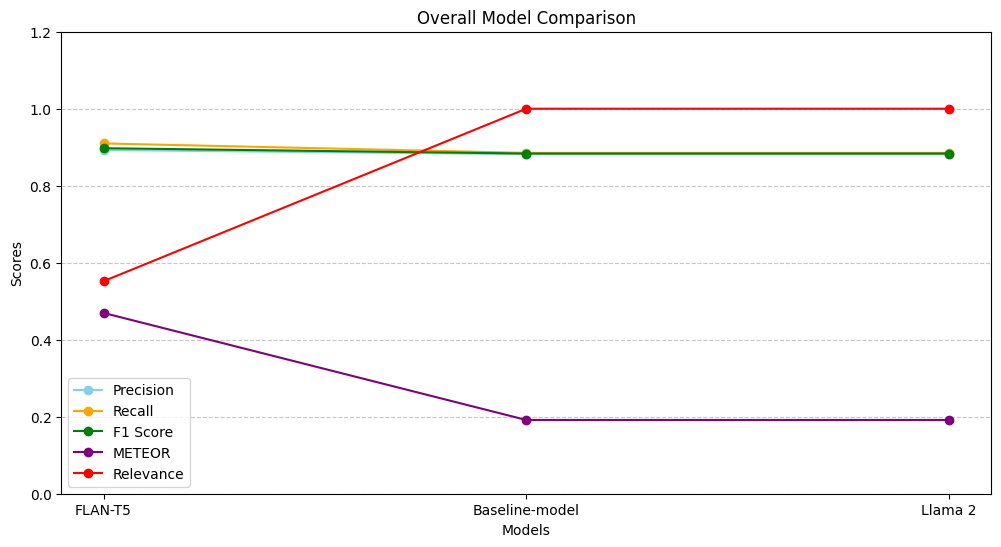

In [ ]:
# Function to Load JSON Scores
def load_scores(file_name):
    file_path = os.path.join(file_name)
    with open(file_path, "r") as f:
        return json.load(f)

# Load Scores from JSON files
flan_t5_scores = load_scores("/content/flan-t5-small-evaluation.json")
t5_base_scores = load_scores("/content/baseline_evaluation_results.json")
llama2_scores = load_scores("/content/Llama2_evaluation_results.json")

# Extract Model Names
models = ["FLAN-T5", "Baseline-model", "Llama 2"]

# Function to Compute Mean for Each Score (Handles Lists and Scalars)
def mean_score(score):
    return np.mean(score) if isinstance(score, list) else score

# BERTScore Data (Extract and Compute Averages)
bertscore_data = {
    "Model": models,
    "Precision": [
        mean_score(flan_t5_scores["BERTScore"]["precision"]),
        mean_score(t5_base_scores["BERTScore"]["precision"]),
        mean_score(llama2_scores["BERTScore"]["precision"])
    ],
    "Recall": [
        mean_score(flan_t5_scores["BERTScore"]["recall"]),
        mean_score(t5_base_scores["BERTScore"]["recall"]),
        mean_score(llama2_scores["BERTScore"]["recall"])
    ],
    "F1 Score": [
        mean_score(flan_t5_scores["BERTScore"]["f1"]),
        mean_score(t5_base_scores["BERTScore"]["f1"]),
        mean_score(llama2_scores["BERTScore"]["f1"])
    ]
}

# METEOR and Relevance Data
# Extract METEOR scores as numeric values
meteor_data = [
    flan_t5_scores["METEOR"]["score"] if isinstance(flan_t5_scores["METEOR"], dict) else flan_t5_scores["METEOR"],
    t5_base_scores["METEOR"]["score"] if isinstance(t5_base_scores["METEOR"], dict) else t5_base_scores["METEOR"],
    llama2_scores["METEOR"]["score"] if isinstance(llama2_scores["METEOR"], dict) else llama2_scores["METEOR"]
]

# Extract Relevance scores as numeric values
relevance_data = [
    flan_t5_scores["Relevance"]["average"] if isinstance(flan_t5_scores["Relevance"], dict) else flan_t5_scores["Relevance"],
    t5_base_scores["Relevance"]["average"] if isinstance(t5_base_scores["Relevance"], dict) else t5_base_scores["Relevance"],
    llama2_scores["Relevance"]["average"] if isinstance(llama2_scores["Relevance"], dict) else llama2_scores["Relevance"]
]


# Convert Data to Pandas DataFrame
bertscore_df = pd.DataFrame({
    "Model": models * 3,
    "Metric": ["Precision", "Recall", "F1 Score"] * len(models),
    "Score": (
        bertscore_data["Precision"] +
        bertscore_data["Recall"] +
        bertscore_data["F1 Score"]
    )
})

# Plot BERTScore Comparison - Bar Chart
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(models))

plt.bar(index, bertscore_data["Precision"], bar_width, label='Precision', color='skyblue')
plt.bar(index + bar_width, bertscore_data["Recall"], bar_width, label='Recall', color='orange')
plt.bar(index + 2 * bar_width, bertscore_data["F1 Score"], bar_width, label='F1 Score', color='green')

plt.xlabel('Models')
plt.ylabel('BERTScore')
plt.title('BERTScore Comparison')
plt.xticks(index + bar_width, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot METEOR Comparison - Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=meteor_data, palette="magma")
plt.title("METEOR Comparison")
plt.xlabel("Models")
plt.ylabel("METEOR Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Relevance Comparison - Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=relevance_data, palette="viridis")
plt.title("Relevance Comparison")
plt.xlabel("Models")
plt.ylabel("Relevance Score")
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Line Chart for Overall Comparison
plt.figure(figsize=(12, 6))
plt.plot(models, bertscore_data["Precision"], marker='o', linestyle='-', label='Precision', color='skyblue')
plt.plot(models, bertscore_data["Recall"], marker='o', linestyle='-', label='Recall', color='orange')
plt.plot(models, bertscore_data["F1 Score"], marker='o', linestyle='-', label='F1 Score', color='green')
plt.plot(models, meteor_data, marker='o', linestyle='-', label='METEOR', color='purple')
plt.plot(models, relevance_data, marker='o', linestyle='-', label='Relevance', color='red')

plt.title("Overall Model Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


**Adaptive Difficulty (Prompt Engineering)**

In [ ]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_accumulated_memory_stats()


/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
# Load T5 Model and Tokenizer
model_checkpoint = "google/flan-t5-small"  # Choose a lightweight model for efficiency
tokenizer = T5TokenizerFast.from_pretrained(model_checkpoint)
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint).to("cuda")
model.eval()  # Set to evaluation mode

In [ ]:
prompt_templates = {
    "easy": "Generate a simple, factual question about a specific detail in: {}",
    "medium": "Generate an analytical question requiring reasoning about the strategic impact of: {}",
    "hard": "Generate a thought-provoking question comparing historical contexts or ethical implications of: {}, ensuring it avoids repetition and uses specific details from the context"
}

In [ ]:
# Function to Generate Questions with Contextual Depth
def generate_difficulty_question(context, difficulty):
    # Use appropriate prompt template
    prompt = prompt_templates[difficulty].format(context)

    # Tokenize and Prepare Input
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    ).to("cuda")

    # Generate Output with Beam Search for Coherence and Diversity
    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_length=80,  # Limit length for efficiency
            num_beams=5,   # Beam Search for Coherence
            no_repeat_ngram_size=3,  # Avoid repetition
            early_stopping=True
        )

    # Decode Output and Clean Up
    question = tokenizer.decode(outputs[0], skip_special_tokens=True)
    question = re.sub(r'\s+', ' ', question).strip()

    # Post-Processing: Ensure Valid Question Structure
    if not question[0].isupper():
        question = question.capitalize()
    if not question.endswith("?"):
        question += "?"

    # Grammar and Uniqueness Checks
    if len(question.split()) < 5 or question in context:
        question = "What is the main idea of the context?"

    # Clear Memory
    del inputs, outputs
    torch.cuda.empty_cache()

    return question

In [ ]:
def adaptive_difficulty(context, reference):
    difficulty_levels = ["easy", "medium", "hard"]
    generated_questions = []
    seen_questions = set()

    for difficulty in difficulty_levels:
        print(f"\nGenerating {difficulty} question...")
        question = generate_difficulty_question(context, difficulty)
        # Ensure uniqueness
        if question in seen_questions or len(question.split()) < 5:
            question = f"What is a key {difficulty} aspect of {context.split('.')[0]}?"
            if question in seen_questions:
                question += f" related to {difficulty} challenges?"
        seen_questions.add(question)
        print(f"Difficulty: {difficulty}")
        print(f"Generated Question: {question}\n")
        generated_questions.append(question)

    print("\nFinal Generated Questions:")
    for idx, q in enumerate(generated_questions, 1):
        print(f"{idx}. {q}")

    return generated_questions

In [ ]:

# Example Context and Reference
context = "Artificial intelligence is revolutionizing various industries, from healthcare to finance. It enhances productivity, automates tasks, and provides insights through data analysis."
reference = [
    "What impact does AI have on the job market?",
    "How can AI be ethically implemented in healthcare?",
    "What are the risks and benefits of using AI for financial decision-making?"
]


# Run Adaptive Difficulty Prompt Engineering
adaptive_difficulty(context, reference)


Generating easy question...
Difficulty: easy
Generated Question: What is the name of the technology that is revolutionizing various industries?


Generating medium question...
Difficulty: medium
Generated Question: What is the strategic impact of Artificial Intelligence?


Generating hard question...
Difficulty: hard
Generated Question: Which of the following is an example of artificial intelligence?


Final Generated Questions:
1. What is the name of the technology that is revolutionizing various industries?
2. What is the strategic impact of Artificial Intelligence?
3. Which of the following is an example of artificial intelligence?


['What is the name of the technology that is revolutionizing various industries?',
 'What is the strategic impact of Artificial Intelligence?',
 'Which of the following is an example of artificial intelligence?']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


📊 Question Evaluation Results:


,Generated Question,BERT Precision,BERT Recall,BERT F1,METEOR,Token F1,Relevance
0,What is the name of the technology that is rev...,0.489857,0.722203,0.599795,0.489474,0.500000,0.855783
1,What is the strategic impact of Artificial Int...,0.632836,0.582799,0.608966,0.459259,0.400000,0.891842
2,Which of the following is an example of artifi...,0.608445,0.751658,0.678456,0.751996,0.705882,0.862931


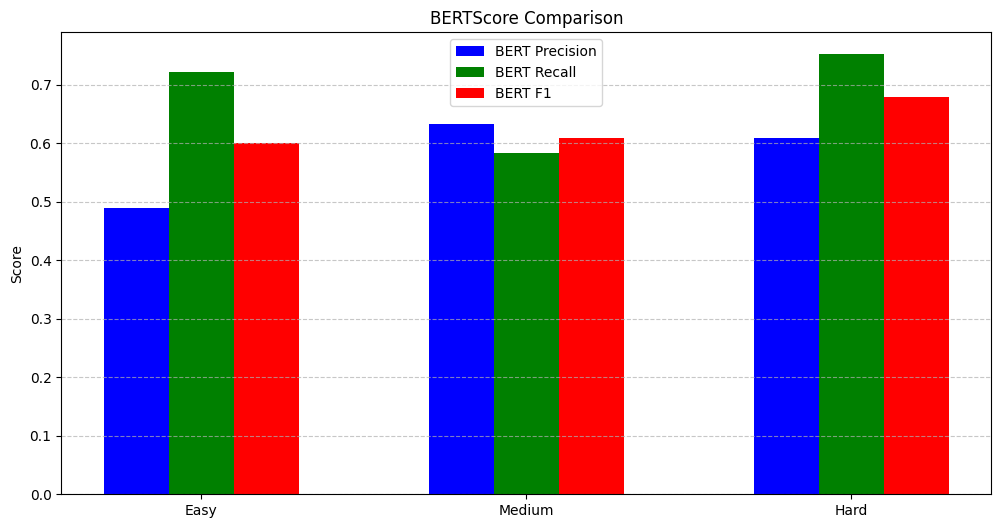

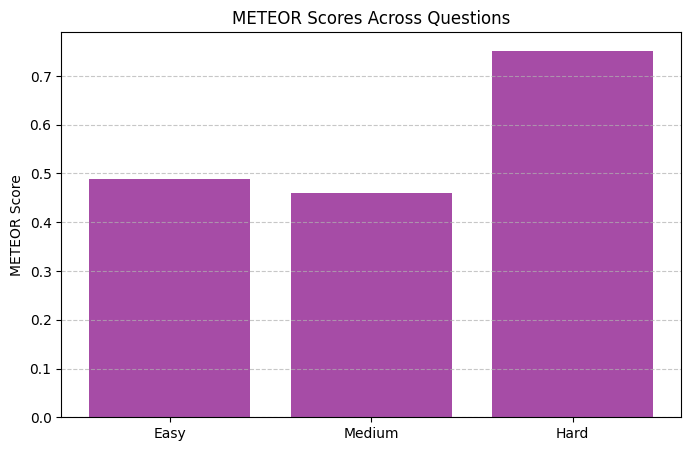

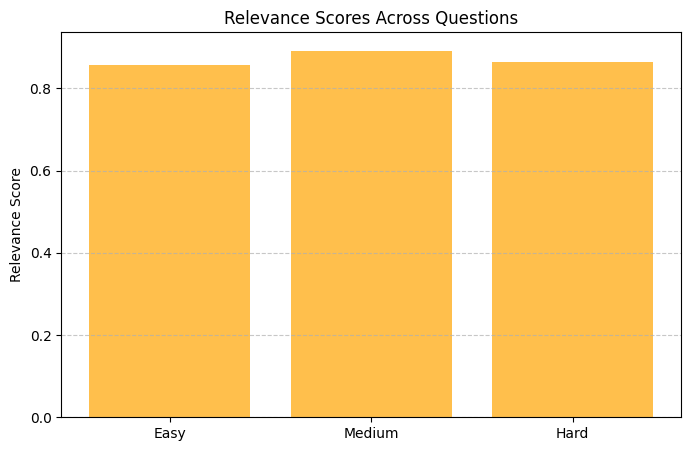

In [ ]:

nltk.download('punkt')  # For tokenization
nltk.download('wordnet')  # Needed for METEOR
nltk.download('omw-1.4')

# ==========================
# 2. Reference and Generated Questions
# ==========================
reference_questions = [
    "What technology is transforming multiple industries?",
    "How does Artificial Intelligence impact strategic decision-making?",
    "Which option represents an example of Artificial Intelligence?"
]

generated_questions = [
    "What is the name of the technology that is revolutionizing various industries?",
    "What is the strategic impact of Artificial Intelligence?",
    "Which of the following is an example of artificial intelligence?"
]

# ==========================
# 3. Compute BERTScore (Force CPU to Avoid Out of Memory)
# ==========================
torch.cuda.empty_cache()  # Free GPU memory

bert_P, bert_R, bert_F1 = bert_score_func(
    generated_questions, reference_questions,
    model_type="microsoft/deberta-base-mnli",  # Smaller model for efficiency
    lang="en",
    device="cpu",  # Force CPU execution
    batch_size=1,  # Reduce memory usage
    rescale_with_baseline=True
)

# ==========================
# 4. Compute METEOR Scores (Tokenized Input)
# ==========================
tokenized_reference_questions = [word_tokenize(ref) for ref in reference_questions]
tokenized_generated_questions = [word_tokenize(gen) for gen in generated_questions]

meteor_scores = [
    meteor_score([ref], gen)
    for ref, gen in zip(tokenized_reference_questions, tokenized_generated_questions)
]

# ==========================
# 5. Compute Token-Level F1 Score
# ==========================
def compute_token_f1(reference, candidate):
    ref_tokens = set(reference.lower().split())
    gen_tokens = set(candidate.lower().split())

    tp = len(ref_tokens & gen_tokens)  # True Positives
    fp = len(gen_tokens - ref_tokens)  # False Positives
    fn = len(ref_tokens - gen_tokens)  # False Negatives

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1

token_f1_scores = [compute_token_f1(ref, gen) for ref, gen in zip(reference_questions, generated_questions)]

# ==========================
# 6. Compute Relevance Score (Cosine Similarity - Force CPU)
# ==========================
# Load the model on CPU to prevent Out of Memory errors
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# Compute sentence embeddings without converting to tensors
ref_embeddings = model.encode(reference_questions, convert_to_tensor=False)
gen_embeddings = model.encode(generated_questions, convert_to_tensor=False)

# Compute cosine similarity for relevance
relevance_scores = [
    float(util.pytorch_cos_sim(ref_embeddings[i], gen_embeddings[i])[0][0])
    for i in range(len(reference_questions))
]

# ==========================
# 7. Store and Display Results
# ==========================
results_df = pd.DataFrame({
    "Generated Question": generated_questions,
    "BERT Precision": bert_P.numpy(),
    "BERT Recall": bert_R.numpy(),
    "BERT F1": bert_F1.numpy(),
    "METEOR": meteor_scores,
    "Token F1": token_f1_scores,
    "Relevance": relevance_scores
})

# Display DataFrame in Jupyter Notebook / Colab
from IPython.display import display

print("📊 Question Evaluation Results:")
display(results_df)

# ==========================
# 8. Plot the Scores
# ==========================
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(generated_questions))

plt.bar(index, bert_P.numpy(), bar_width, label='BERT Precision', color='blue')
plt.bar(index + bar_width, bert_R.numpy(), bar_width, label='BERT Recall', color='green')
plt.bar(index + 2 * bar_width, bert_F1.numpy(), bar_width, label='BERT F1', color='red')

plt.xticks(index + bar_width, ["Easy", "Medium", "Hard"])
plt.ylabel("Score")
plt.title("BERTScore Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot METEOR Scores
plt.figure(figsize=(8, 5))
plt.bar(["Easy", "Medium", "Hard"], meteor_scores, color='purple', alpha=0.7)
plt.ylabel("METEOR Score")
plt.title("METEOR Scores Across Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Relevance Scores
plt.figure(figsize=(8, 5))
plt.bar(["Easy", "Medium", "Hard"], relevance_scores, color='orange', alpha=0.7)
plt.ylabel("Relevance Score")
plt.title("Relevance Scores Across Questions")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**SHAP values for interpretation**

In [ ]:
# Install dependencies (Uncomment if running in a fresh environment)
# !pip install transformers torch

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Device Setup
device = "cpu"  # Using CPU to avoid GPU memory issues
print(f"Using device: {device}")

# ** Using a Fine-Tuned Sentiment Analysis Model **
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Fine-tuned for sentiment analysis

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to CPU
model.to(device)
model.eval()

print("✅ Model loaded successfully!")


Using device: cpu


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ Model loaded successfully!


In [ ]:
context = "Artificial intelligence is transforming industries with automation and data-driven insights. However, ethical considerations like bias, privacy, and accountability are crucial."
background_texts = [
    "AI is making healthcare more efficient but raises ethical concerns about patient privacy.",
    "Automation is improving productivity but may lead to job losses.",
    "Ethical AI is necessary to ensure fairness and accountability in decision-making."
]


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Values Shape: (1, 16, 2)
Number of Classes: 1


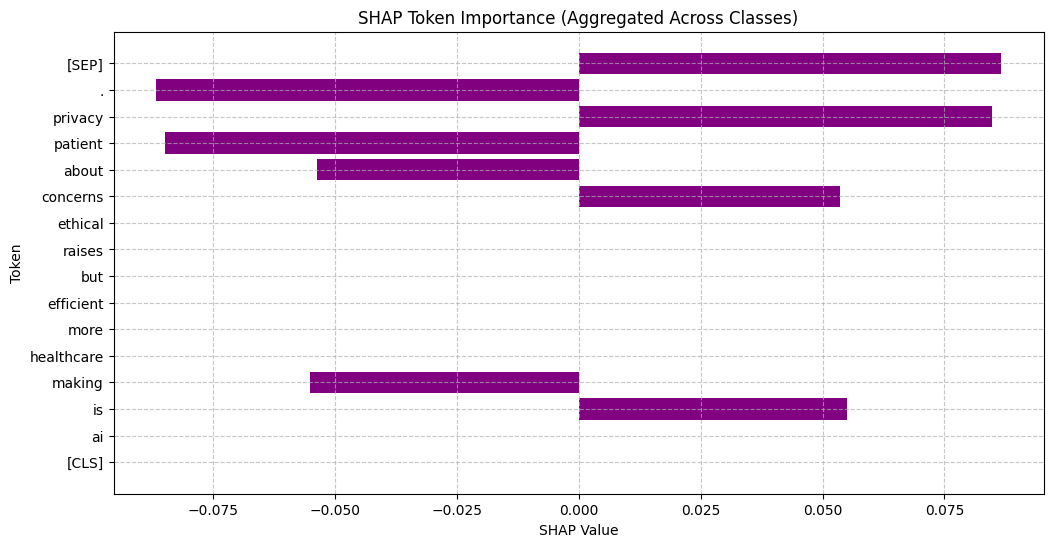

In [ ]:

# Custom Prediction Function for SHAP
def predict(texts):
    # Convert NumPy array to list of strings if needed
    if isinstance(texts, np.ndarray):
        texts = [tokenizer.decode(text, skip_special_tokens=True) for text in texts]

    # Tokenize Inputs
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    # Make Predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get Probabilities
    logits = outputs.logits.cpu().numpy()
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    return probabilities

# Tokenize Background Texts and Convert to NumPy Array
background_inputs = tokenizer(
    background_texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)
background_texts_np = background_inputs['input_ids'].cpu().numpy()

# Use SHAP KernelExplainer with More Samples
explainer = shap.KernelExplainer(predict, background_texts_np)
input_data = np.expand_dims(background_texts_np[0], axis=0)
shap_values = explainer.shap_values(input_data, nsamples=50)  # Increased nsamples for better accuracy

# Tokenization for SHAP Visualization
tokens = tokenizer.convert_ids_to_tokens(background_inputs['input_ids'][0])

# Debugging: Check SHAP Values Shape
print("SHAP Values Shape:", np.array(shap_values).shape)

# Check the Number of Classes in SHAP Values
num_classes = len(shap_values)
print("Number of Classes:", num_classes)

# ** Aggregate SHAP Values Across Classes **
if num_classes > 1:
    # Average SHAP values across both classes
    shap_values_class = np.mean(shap_values, axis=0).flatten()
else:
    # Use the only available class
    shap_values_class = shap_values[0].flatten()

# ** Ensure Matching Lengths **
shap_values_class = shap_values_class[:len(tokens)]

# ** Visualization: SHAP Token Importance as Horizontal Bar Plot **
plt.figure(figsize=(12, 6))
plt.barh(tokens, shap_values_class, color='purple')
plt.xlabel("SHAP Value")
plt.ylabel("Token")
plt.title("SHAP Token Importance (Aggregated Across Classes)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
